In [63]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

In [2]:
train = pd.read_csv('train_property_data.csv')
test = pd.read_csv('test_property_data.csv')

In [3]:
train.head()

,house_id,state,zipcode,county_fips,total_bath_count,year_built,building_area_sq_ft,property_type,exterior_walls,water,sewer,heating,heating_fuel_type,fireplace,style,garage_type_parking,title_check_date,lien_amount
0,0,AZ,85042,4013.0,3.67,2005.0,2121.0,Single Family Residential,wood,NaN,NaN,yes,NaN,False,NaN,garage,2012-02-10,0.0
1,1,AZ,85037,4013.0,3.00,1975.0,1783.0,Single Family Residential,wood,NaN,NaN,yes,NaN,False,NaN,NaN,2013-01-17,0.0
2,3,AZ,85233,4013.0,2.33,1984.0,1592.0,Single Family Residential,wood,NaN,NaN,yes,NaN,False,NaN,garage,2012-01-17,0.0
3,8,AZ,85032,4013.0,2.00,1972.0,1640.0,Single Family Residential,wood,NaN,NaN,yes,NaN,False,NaN,garage,2012-02-27,0.0
4,11,AZ,85326,4013.0,3.67,2005.0,3784.0,Single Family Residential,wood,NaN,NaN,yes,NaN,False,NaN,garage,2012-01-05,0.0


## Handle missing values

In [4]:
# Fill missing values with 'unknown'
cols_to_fill = ['property_type', 'exterior_walls', 'water', 'sewer', 
                'heating', 'heating_fuel_type', 'fireplace', 'style', 'garage_type_parking']
for df in [train, test]:
    for col in cols_to_fill:
        df[col].fillna('unknown', inplace=True)

# Drop 'county_fips'
train.drop(['county_fips'], axis=1, inplace=True)
test.drop(['county_fips'], axis=1, inplace=True)

In [5]:
train.head()

,house_id,state,zipcode,total_bath_count,year_built,building_area_sq_ft,property_type,exterior_walls,water,sewer,heating,heating_fuel_type,fireplace,style,garage_type_parking,title_check_date,lien_amount
0,0,AZ,85042,3.67,2005.0,2121.0,Single Family Residential,wood,unknown,unknown,yes,unknown,False,unknown,garage,2012-02-10,0.0
1,1,AZ,85037,3.00,1975.0,1783.0,Single Family Residential,wood,unknown,unknown,yes,unknown,False,unknown,unknown,2013-01-17,0.0
2,3,AZ,85233,2.33,1984.0,1592.0,Single Family Residential,wood,unknown,unknown,yes,unknown,False,unknown,garage,2012-01-17,0.0
3,8,AZ,85032,2.00,1972.0,1640.0,Single Family Residential,wood,unknown,unknown,yes,unknown,False,unknown,garage,2012-02-27,0.0
4,11,AZ,85326,3.67,2005.0,3784.0,Single Family Residential,wood,unknown,unknown,yes,unknown,False,unknown,garage,2012-01-05,0.0


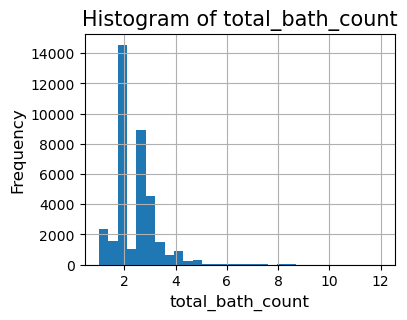

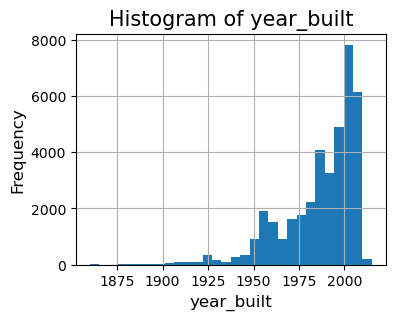

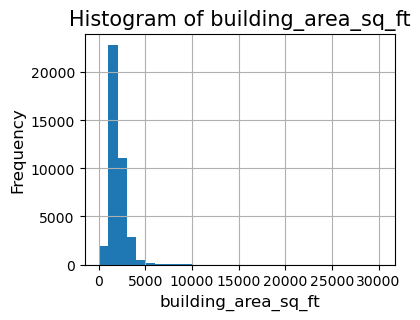

In [6]:
# list of column names to plot
columns_to_plot = ['total_bath_count', 'year_built', 'building_area_sq_ft']

# loop over the list and plot a histogram for each variable
for column in columns_to_plot:
    plt.figure(figsize=(4,3))
    train[column].hist(bins=30)
    plt.title(f'Histogram of {column}', size=15)
    plt.xlabel(column, size=12)
    plt.ylabel('Frequency', size=12)
    plt.show()


In [7]:
# define columns to be filled
columns_to_fill = ['total_bath_count', 'year_built', 'building_area_sq_ft']

# replace missing values with the mode of each group
for df in [train, test]:
    for col in columns_to_fill:
        df[col].fillna(df.groupby('zipcode')[col].transform(lambda x: x.mode()[0] if not x.mode().empty else np.nan), inplace=True)


### Replace remaining nans

In [8]:
for df in [train, test]:
    for col in columns_to_fill:
        df[col].fillna(df[col].mode()[0], inplace=True)

In [9]:
train.head()

,house_id,state,zipcode,total_bath_count,year_built,building_area_sq_ft,property_type,exterior_walls,water,sewer,heating,heating_fuel_type,fireplace,style,garage_type_parking,title_check_date,lien_amount
0,0,AZ,85042,3.67,2005.0,2121.0,Single Family Residential,wood,unknown,unknown,yes,unknown,False,unknown,garage,2012-02-10,0.0
1,1,AZ,85037,3.00,1975.0,1783.0,Single Family Residential,wood,unknown,unknown,yes,unknown,False,unknown,unknown,2013-01-17,0.0
2,3,AZ,85233,2.33,1984.0,1592.0,Single Family Residential,wood,unknown,unknown,yes,unknown,False,unknown,garage,2012-01-17,0.0
3,8,AZ,85032,2.00,1972.0,1640.0,Single Family Residential,wood,unknown,unknown,yes,unknown,False,unknown,garage,2012-02-27,0.0
4,11,AZ,85326,3.67,2005.0,3784.0,Single Family Residential,wood,unknown,unknown,yes,unknown,False,unknown,garage,2012-01-05,0.0


In [10]:
# Convert the 'zipcode' column in both datasets to sets
train_zipcodes = set(train['zipcode'])
test_zipcodes = set(test['zipcode'])

# Find the zip codes that are in the test set but not the train set
new_zipcodes = test_zipcodes - train_zipcodes

# Calculate the proportion of these new zip codes in the test set
proportion = len(new_zipcodes) / len(test_zipcodes)

print('Proportion of zip codes in test set not present in training set: ', proportion)


Proportion of zip codes in test set not present in training set:  0.02492877492877493


In [11]:
# Create a dictionary with the mean 'lien_amount' for each zip code in the training set
zip_mean_dict = train.groupby('zipcode')['lien_amount'].mean().to_dict()

# Replace the zip codes in the test set with the mean 'lien_amount' from the training set
test['zipcode'] = test['zipcode'].map(zip_mean_dict)
train['zipcode'] = train['zipcode'].map(zip_mean_dict)

# For the zip codes in the test set not present in the training set, replace them with the overall mean 'lien_amount'
test['zipcode'].fillna(train['lien_amount'].mean(), inplace=True)

In [12]:
train.drop(columns=['title_check_date'], inplace=True)
test.drop(columns=['title_check_date'], inplace=True)

## Compare distribution of the data

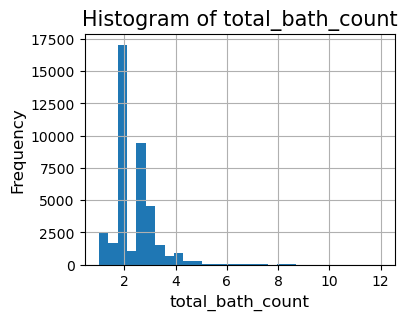

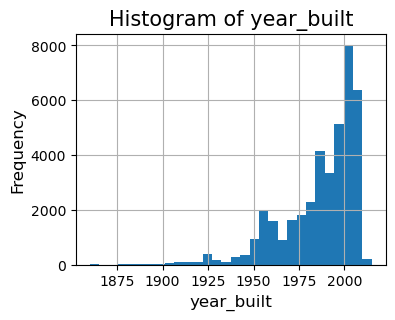

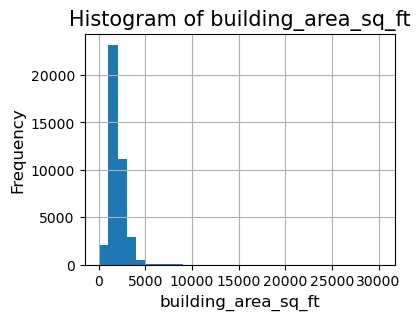

In [13]:
# list of column names to plot
columns_to_plot = ['total_bath_count', 'year_built', 'building_area_sq_ft']

# loop over the list and plot a histogram for each variable
for column in columns_to_plot:
    plt.figure(figsize=(4,3))
    train[column].hist(bins=30)
    plt.title(f'Histogram of {column}', size=15)
    plt.xlabel(column, size=12)
    plt.ylabel('Frequency', size=12)
    plt.show()

In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   house_id             40000 non-null  int64  
 1   state                40000 non-null  object 
 2   zipcode              40000 non-null  float64
 3   total_bath_count     40000 non-null  float64
 4   year_built           40000 non-null  float64
 5   building_area_sq_ft  40000 non-null  float64
 6   property_type        40000 non-null  object 
 7   exterior_walls       40000 non-null  object 
 8   water                40000 non-null  object 
 9   sewer                40000 non-null  object 
 10  heating              40000 non-null  object 
 11  heating_fuel_type    40000 non-null  object 
 12  fireplace            40000 non-null  object 
 13  style                40000 non-null  object 
 14  garage_type_parking  40000 non-null  object 
 15  lien_amount          40000 non-null 

In [15]:
cat_cols = ['state', 'property_type', 'exterior_walls', 'water', 'sewer', 'heating', 
            'heating_fuel_type', 'fireplace', 'style', 'garage_type_parking']
num_cols = ['building_area_sq_ft', 'total_bath_count', 'zipcode']

In [16]:
# Convert all categorical columns to strings
for col in cat_cols:
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)


In [17]:


# One-hot encoding for categorical columns
ohe = OneHotEncoder(drop='first', sparse=False)
ohe.fit(train[cat_cols])  # Fit on the train data

# Transform on training data
X_cat_train = ohe.transform(train[cat_cols])
X_cat_train = pd.DataFrame(X_cat_train, columns=ohe.get_feature_names(cat_cols))

# Transform on testing data
X_cat_test = ohe.transform(test[cat_cols])
X_cat_test = pd.DataFrame(X_cat_test, columns=ohe.get_feature_names(cat_cols))


/Users/orabi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/orabi/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [18]:


# Standardization for numerical columns
scaler = StandardScaler()
scaler.fit(train[num_cols])  # Fit on the train data

# Transform on training data
X_num_train = scaler.transform(train[num_cols])
X_num_train = pd.DataFrame(X_num_train, columns=num_cols)

# Transform on testing data
X_num_test = scaler.transform(test[num_cols])
X_num_test = pd.DataFrame(X_num_test, columns=num_cols)


In [19]:
# Concatenating processed numerical and categorical dfs
train_processed = pd.concat([X_num_train.reset_index(drop=True), 
                             X_cat_train.reset_index(drop=True)], axis=1)

test_processed = pd.concat([X_num_test.reset_index(drop=True), 
                            X_cat_test.reset_index(drop=True)], axis=1)


In [20]:
train_processed.head()

,building_area_sq_ft,total_bath_count,zipcode,state_CA,state_FL,state_GA,state_IL,state_NC,state_NV,state_WA,...,garage_type_parking_built_in,garage_type_parking_carport,garage_type_parking_detached_garage,garage_type_parking_garage,garage_type_parking_mixed,garage_type_parking_none,garage_type_parking_paved_surfaced,garage_type_parking_underground_basement,garage_type_parking_unknown,garage_type_parking_yes
0,0.258208,1.840063,-0.098229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.155549,0.910145,0.088873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.389358,-0.019773,-0.288639,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.330600,-0.477793,-0.257718,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2.293939,1.840063,-0.147707,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


# Training

In [21]:



# Define the features (X) and the target (y)
X = train_processed
y = train['lien_amount']

# Split the data into training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Validation RMSE: 15117.6633


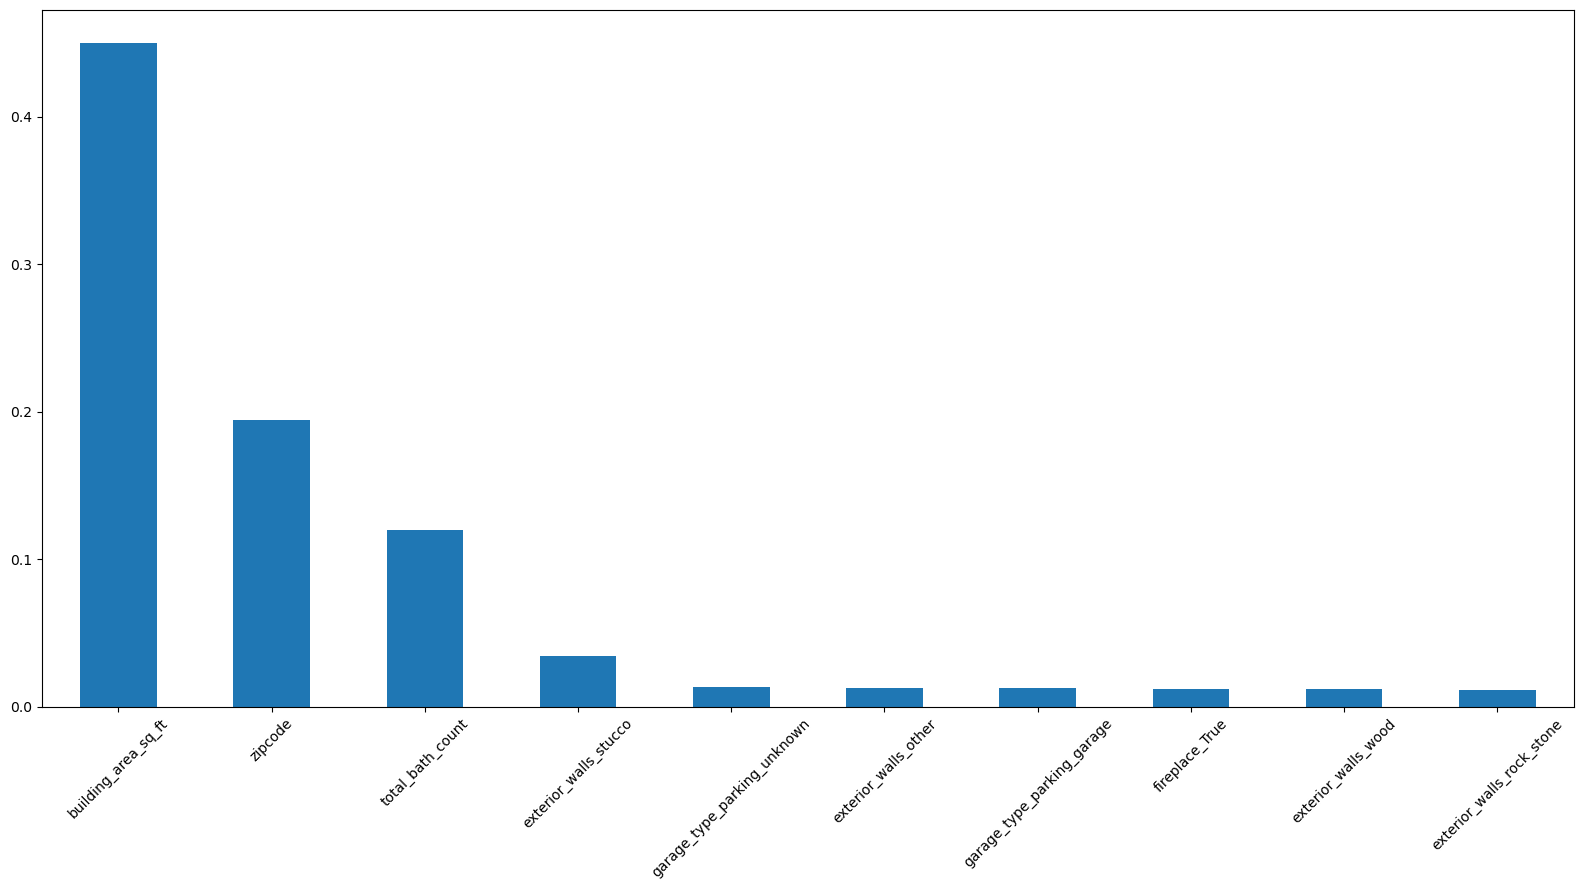

In [22]:


# Predict on the validation set
y_pred = rf.predict(X_valid)

# Compute and print the RMSE
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Validation RMSE: {rmse:.4f}')

# Get feature importances
importances = rf.feature_importances_

# Convert the importances into one-dimensional 1darray with corresponding df column names as axis labels
f_importances = pd.Series(importances, train_processed.columns)

# Sort the array in descending order of the importances
f_importances.sort_values(ascending=False, inplace=True)

# Draw the bar Plot from f_importances 
f_importances.iloc[:10].plot(x='Features', y='Importance', kind='bar', figsize=(16,9), rot=45)

# Show the plot
plt.tight_layout()
plt.show()


## PCA

In [26]:

# Apply PCA
pca = PCA(n_components=10)  # Choose the desired number of components
pca_features = pca.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(pca_features, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print("Validation RMSE:", rmse)

Validation RMSE: 16002.493648608406


## Classification

In [46]:
train_processed['risky'] = train['lien_amount'].apply(lambda x: 1 if x > 0 else 0)


In [47]:
X = train_processed.drop(['risky'], axis=1)
y = train_processed['risky']

In [48]:


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
pca = PCA(n_components=15)  # Adjust the number of components as needed
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [49]:


classifier = RandomForestClassifier()
classifier.fit(X_train, y_train)


RandomForestClassifier()

In [50]:


y_pred = classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.876875


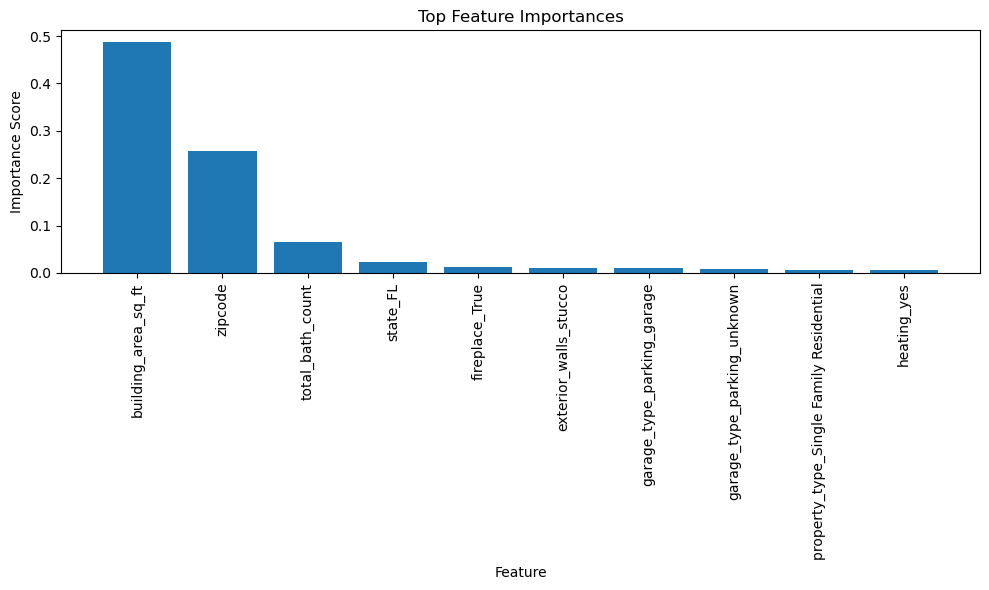

In [51]:


# Get feature importances
importances = classifier.feature_importances_
feature_names = X.columns

# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

# Select the top n features to display
n = 10  # Adjust the number of top features to display
top_indices = indices[:n]
top_importances = importances[top_indices]
top_feature_names = feature_names[top_indices]

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(n), top_importances, align='center')
plt.xticks(range(n), top_feature_names, rotation='vertical')
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Top Feature Importances')
plt.tight_layout()
plt.show()

In [57]:
train_processed.risky.value_counts()

0    36000
1     4000
Name: risky, dtype: int64

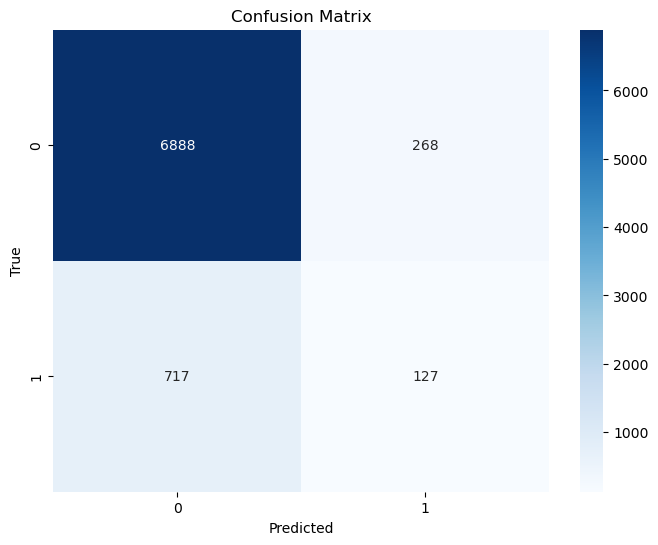

In [59]:



# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


## SMOTE

In [61]:


# Separate features and target variable
X = train_processed.drop('risky', axis=1)
y = train_processed['risky']

# Instantiate SMOTE
smote = SMOTE(sampling_strategy='auto')

# Oversample the minority class
X_resampled, y_resampled = smote.fit_resample(X, y)


In [62]:


# Split the resampled data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train the RandomForestClassifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_classifier.predict(X_test)

# Calculate precision, recall, and accuracy
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)


Precision: 0.8793628808864266
Recall: 0.889340243731615
Accuracy: 0.8846527777777777
